<a href="https://colab.research.google.com/github/ritwiks9635/Segmentation-Model/blob/main/POINT_CLOUD_SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**🌜Point ☁️🌤Cloud Segmentation🌛**

In [ ]:
!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

import tensorflow as tf  # For tf.data
import keras
from keras import layers

import matplotlib.pyplot as plt

In [ ]:
dataset_url = "https://git.io/JiY4i"

dataset_path = keras.utils.get_file(
    fname="shapenet.zip",
    origin=dataset_url,
    cache_subdir="datasets",
    hash_algorithm="auto",
    extract=True,
    archive_format="auto",
    cache_dir="datasets",
)

1078925405/1078925405 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [ ]:
with open("/tmp/.keras/datasets/PartAnnotation/metadata.json") as json_file:
    metadata = json.load(json_file)

print(metadata)

{'Airplane': {'directory': '02691156', 'lables': ['wing', 'body', 'tail', 'engine'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Bag': {'directory': '02773838', 'lables': ['handle', 'body'], 'colors': ['blue', 'green']}, 'Cap': {'directory': '02954340', 'lables': ['panels', 'peak'], 'colors': ['blue', 'green']}, 'Car': {'directory': '02958343', 'lables': ['wheel', 'hood', 'roof'], 'colors': ['blue', 'green', 'red']}, 'Chair': {'directory': '03001627', 'lables': ['leg', 'arm', 'back', 'seat'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Earphone': {'directory': '03261776', 'lables': ['earphone', 'headband'], 'colors': ['blue', 'green']}, 'Guitar': {'directory': '03467517', 'lables': ['head', 'body', 'neck'], 'colors': ['blue', 'green', 'red']}, 'Knife': {'directory': '03624134', 'lables': ['handle', 'blade'], 'colors': ['blue', 'green']}, 'Lamp': {'directory': '03636649', 'lables': ['canopy', 'lampshade', 'base'], 'colors': ['blue', 'green', 'red']}, 'Laptop': {'directory': '0364280

In [ ]:
points_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points".format(
    metadata["Airplane"]["directory"]
)
labels_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points_label".format(
    metadata["Airplane"]["directory"]
)
labels = metadata["Airplane"]["lables"]
colors = metadata["Airplane"]["colors"]

val_split = 0.2
num_sample_points = 1024
batch_size = 32
epochs = 60
learning_rate = 1e-3

## Structuring the dataset

We generate the following in-memory data structures from the Airplane point clouds and
their labels:

- `point_clouds` is a list of `np.array` objects that represent the point cloud data in
the form of x, y and z coordinates. Axis 0 represents the number of points in the
point cloud, while axis 1 represents the coordinates. `all_labels` is the list
that represents the label of each coordinate as a string (needed mainly for
visualization purposes).
- `test_point_clouds` is in the same format as `point_clouds`, but doesn't have
corresponding the labels of the point clouds.
- `all_labels` is a list of `np.array` objects that represent the point cloud labels
for each coordinate, corresponding to the `point_clouds` list.
- `point_cloud_labels` is a list of `np.array` objects that represent the point cloud
labels for each coordinate in one-hot encoded form, corresponding to the `point_clouds`
list.

In [ ]:
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []

points_files = glob(os.path.join(points_dir, "*.pts"))
for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    if point_cloud.shape[0] < num_sample_points:
        continue

    # Get the file-id of the current point cloud for parsing its
    # labels.
    file_id = point_file.split("/")[-1].split(".")[0]
    label_data, num_labels = {}, 0
    for label in labels:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype("float32")
            num_labels = len(label_data[label])

    # Point clouds having labels will be our training samples.
    try:
        label_map = ["none"] * num_labels
        for label in labels:
            for i, data in enumerate(label_data[label]):
                label_map[i] = label if data == 1 else label_map[i]
        label_data = [
            labels.index(label) if label != "none" else len(labels)
            for label in label_map
        ]
        # Apply one-hot encoding to the dense label representation.
        label_data = keras.utils.to_categorical(label_data, num_classes=len(labels) + 1)

        point_clouds.append(point_cloud)
        point_cloud_labels.append(label_data)
        all_labels.append(label_map)
    except KeyError:
        test_point_clouds.append(point_cloud)

100%|██████████| 4045/4045 [02:44<00:00, 24.52it/s]


In [ ]:
point_clouds[0].shape
#print(point_cloud_labels[0].shape)

(2412, 3)

In [ ]:
for _ in range(5):
    i = random.randint(0, len(point_clouds) - 1)
    print(f"point_clouds[{i}].shape:", point_clouds[0].shape)
    print(f"point_cloud_labels[{i}].shape:", point_cloud_labels[0].shape)
    for j in range(5):
        print(
            f"all_labels[{i}][{j}]:",
            all_labels[i][j],
            f"\tpoint_cloud_labels[{i}][{j}]:",
            point_cloud_labels[i][j],
            "\n")

point_clouds[2738].shape: (2412, 3)
point_cloud_labels[2738].shape: (2412, 5)
all_labels[2738][0]: body 	point_cloud_labels[2738][0]: [0. 1. 0. 0. 0.] 

all_labels[2738][1]: body 	point_cloud_labels[2738][1]: [0. 1. 0. 0. 0.] 

all_labels[2738][2]: body 	point_cloud_labels[2738][2]: [0. 1. 0. 0. 0.] 

all_labels[2738][3]: wing 	point_cloud_labels[2738][3]: [1. 0. 0. 0. 0.] 

all_labels[2738][4]: wing 	point_cloud_labels[2738][4]: [1. 0. 0. 0. 0.] 

point_clouds[3101].shape: (2412, 3)
point_cloud_labels[3101].shape: (2412, 5)
all_labels[3101][0]: none 	point_cloud_labels[3101][0]: [0. 0. 0. 0. 1.] 

all_labels[3101][1]: body 	point_cloud_labels[3101][1]: [0. 1. 0. 0. 0.] 

all_labels[3101][2]: none 	point_cloud_labels[3101][2]: [0. 0. 0. 0. 1.] 

all_labels[3101][3]: none 	point_cloud_labels[3101][3]: [0. 0. 0. 0. 1.] 

all_labels[3101][4]: wing 	point_cloud_labels[3101][4]: [1. 0. 0. 0. 0.] 

point_clouds[680].shape: (2412, 3)
point_cloud_labels[680].shape: (2412, 5)
all_labels[680][0]

In [ ]:
def visualize_data(point_cloud, labels):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for index, label in enumerate(labels):
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c= colors[index]
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()

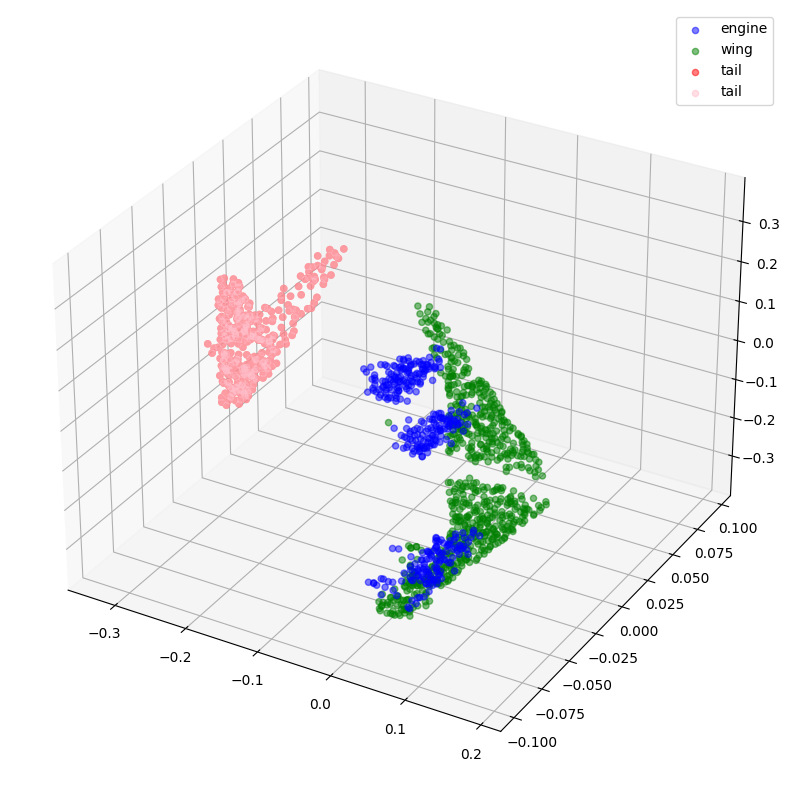

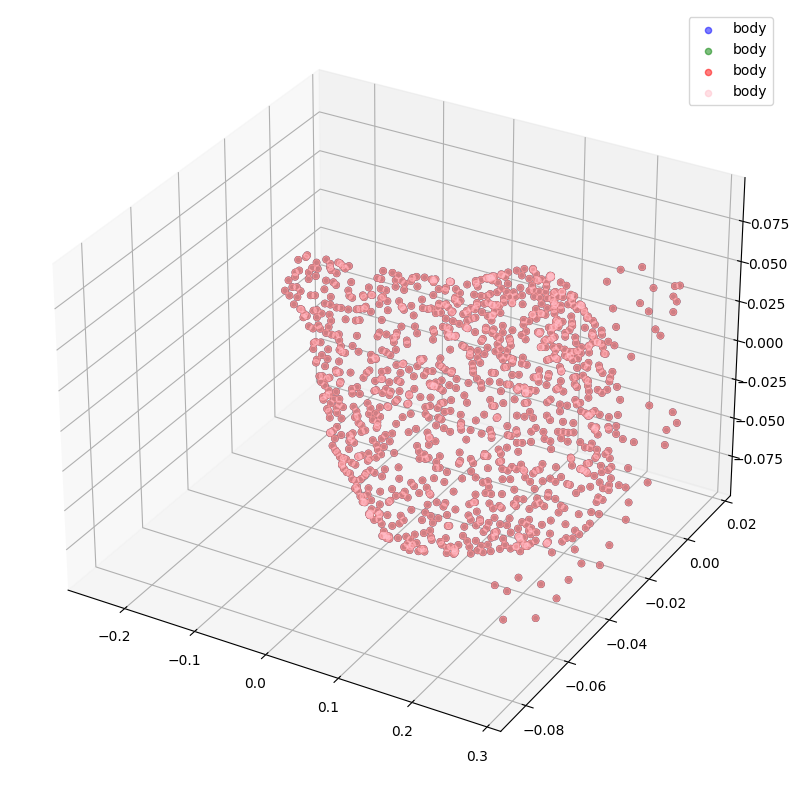

In [ ]:
visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[3], all_labels[3])

In [ ]:
for index in tqdm(range(len(point_clouds))):
    current_point_cloud = point_clouds[index]
    current_label_cloud = point_cloud_labels[index]
    current_labels = all_labels[index]
    num_points = len(current_point_cloud)
    # Randomly sampling respective indices.
    sampled_indices = random.sample(list(range(num_points)), num_sample_points)
    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization.
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud.
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    point_clouds[index] = norm_point_cloud
    point_cloud_labels[index] = sampled_label_cloud
    all_labels[index] = sampled_labels

100%|██████████| 3694/3694 [00:12<00:00, 297.93it/s]


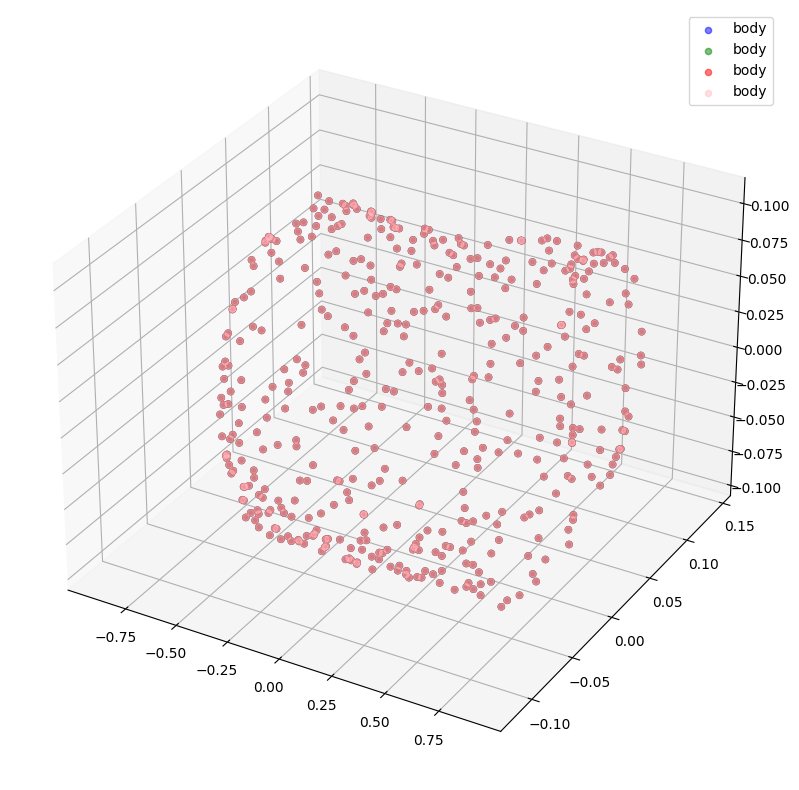

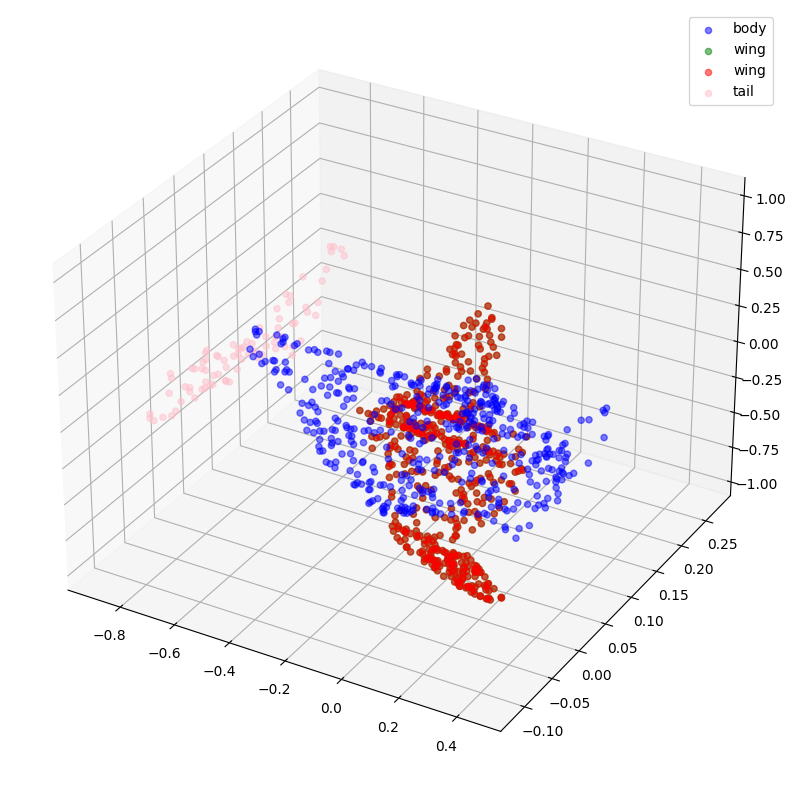

In [ ]:
visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[3], all_labels[3])

## PointNet model

The figure below depicts the internals of the PointNet model family:

![](https://i.imgur.com/qFLNw5L.png)

Given that PointNet is meant to consume an ***unordered set*** of coordinates as its input data,
its architecture needs to match the following characteristic properties
of point cloud data:

### Permutation invariance

Given the unstructured nature of point cloud data, a scan made up of `n` points has `n!`
permutations. The subsequent data processing must be invariant to the different
representations. In order to make PointNet invariant to input permutations, we use a
symmetric function (such as max-pooling) once the `n` input points are mapped to
higher-dimensional space. The result is a **global feature vector** that aims to capture
an aggregate signature of the `n` input points. The global feature vector is used alongside
local point features for segmentation.

![](https://i.imgur.com/0mrvvjb.png)

### Transformation invariance

Segmentation outputs should be unchanged if the object undergoes certain transformations,
such as translation or scaling. For a given input point cloud, we apply an appropriate
rigid or affine transformation to achieve pose normalization. Because each of the `n` input
points are represented as a vector and are mapped to the embedding spaces independently,
applying a geometric transformation simply amounts to matrix multiplying each point with
a transformation matrix. This is motivated by the concept of
[Spatial Transformer Networks](https://arxiv.org/abs/1506.02025).

The operations comprising the T-Net are motivated by the higher-level architecture of
PointNet. MLPs (or fully-connected layers) are used to map the input points independently
and identically to a higher-dimensional space; max-pooling is used to encode a global
feature vector whose dimensionality is then reduced with fully-connected layers. The
input-dependent features at the final fully-connected layer are then combined with
globally trainable weights and biases, resulting in a 3-by-3 transformation matrix.

![](https://i.imgur.com/aEj3GYi.png)

### Point interactions

The interaction between neighboring points often carries useful information (i.e., a
single point should not be treated in isolation). Whereas classification need only make
use of global features, segmentation must be able to leverage local point features along
with global point features.


**Note**: The figures presented in this section have been taken from the
[original paper](https://arxiv.org/abs/1612.00593).



Now that we know the pieces that compose the PointNet model, we can implement the model.
We start by implementing the basic blocks i.e., the convolutional block and the multi-layer
perceptron block.

In [ ]:
def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([num_sample_points, 3])
    label_cloud_batch.set_shape([num_sample_points, len(labels) + 1])
    return point_cloud_batch, label_cloud_batch

def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(tf.shape(label_cloud_batch), -0.001, 0.001, dtype = tf.float64)
    point_cloud_batch += noise[:, :, :3]
    return point_cloud_batch, label_cloud_batch


def data_generator(point_cloud, label_cloud, is_train = True):
    dataset = tf.data.Dataset.from_tensor_slices((point_cloud, label_cloud))
    dataset = dataset.shuffle(batch_size * 100) if is_train else dataset
    dataset = dataset.map(load_data, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = (dataset.map(augment, num_parallel_calls = tf.data.AUTOTUNE)
        if is_train
        else dataset
        )
    return dataset

In [ ]:
split_index = int(len(point_clouds) * (1 - val_split))

train_point_cloud = point_clouds[: split_index]
train_label_cloud = point_cloud_labels[: split_index]

total_training_sample = len(train_point_cloud)

val_point_cloud = point_clouds[split_index :]
val_label_cloud = point_cloud_labels[split_index :]

print("Total Trian point cloud is :: ", len(train_point_cloud))
print("Total Trian label cloud is :: ", len(train_label_cloud))
print("Total Valid point cloud is :: ", len(val_point_cloud))
print("Total Valid label cloud is :: ", len(val_label_cloud))

Total Trian point cloud is ::  2955
Total Trian label cloud is ::  2955
Total Valid point cloud is ::  739
Total Valid label cloud is ::  739


In [ ]:
train_dataset = data_generator(train_point_cloud, train_label_cloud)
valid_dataset = data_generator(val_point_cloud, val_label_cloud, is_train = False)

print("Train Dataset :: ", train_dataset)
print("Validation Dataset ::", valid_dataset)

Train Dataset ::  <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1024, 5), dtype=tf.float64, name=None))>
Validation Dataset :: <_BatchDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1024, 5), dtype=tf.float64, name=None))>


In [ ]:
def conv_block(x, filters, name):
    x = layers.Conv1D(filters, kernel_size = 1, padding = "valid", name = f"{name}_conv")(x)
    x = layers.BatchNormalization(name = f"{name}_batch_normalization")(x)
    x = layers.Activation("relu", name = f"{name}_relu")(x)
    return x


def mlp_block(x, units, name):
    x = layers.Dense(units, name = f"{name}_dense")(x)
    x = layers.BatchNormalization(name = f"{name}_batch_normalization")(x)
    x = layers.Activation("relu", name = f"{name}_relu")(x)
    return x

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg = 0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = keras.ops.eye(num_features)


    def __call__(self, x):
        x = keras.ops.reshape(x, (-1, self.num_features, self.num_features))
        xxt = keras.ops.tensordot(x, x, axes = (2, 2))
        xxt = keras.ops.reshape(xxt, (-1, self.num_features, self.num_features))
        return keras.ops.sum(self.l2reg * keras.ops.square(xxt - self.identity))


    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "num_features" : self.num_features,
                "l2reg_stregth" : self.l2reg
            })
        return config

In [ ]:
def transformation_net(inputs, num_features, name):
    x = conv_block(inputs, filters = 64 , name = f"{name}_1")
    x = conv_block(x, filters = 128, name = f"{name}_2")
    x = conv_block(x, filters = 1024, name = f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)

    x = mlp_block(x, units = 512, name = f"{name}_1_1")
    x = mlp_block(x, units = 256, name = f"{name}_2_1")

    output = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final")(x)

    return output


def transformation_block(inputs, num_features, name):
    transformed_features = transformation_net(inputs, num_features, name = name)
    transformed_features = layers.Reshape((num_features, num_features))(transformed_features)
    return layers.Dot(axes = (2, 1), name = f"{name}_dot")([inputs, transformed_features])

In [ ]:
def get_segmentation_model(num_points, num_classes):
    input_points = keras.Input(shape = (None, 3))

    transformed_inputs = transformation_block(input_points, num_features = 3, name = "input_transformation_block")
    features_64 = conv_block(transformed_inputs, filters = 64, name = "features_64")
    features_128_1 = conv_block(features_64, filters = 128, name = "features_128_1")
    features_128_2 = conv_block(features_128_1, filters = 128, name = "features_128_2")
    transformed_features = transformation_block(features_128_2, num_features = 128, name = "transformed_features")
    features_512 = conv_block(transformed_features, filters = 512, name = "features_512")
    features_2048 = conv_block(features_512, filters = 2048, name = "features_2048")
    pool_layer = layers.MaxPooling1D(pool_size = num_points, name = "pool_features")(features_2048)

    pool_layer = keras.ops.tile(pool_layer, [1, num_points, 1])

    segmentation_inputs = layers.Concatenate(name = "segmentation_inputs")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            pool_layer
        ])

    segmentation_features = conv_block(segmentation_inputs, filters = 128, name = "segmentation_features")
    outputs = layers.Conv1D(num_classes, kernel_size = 1, activation = "softmax", name = "segmentation_output")(segmentation_features)
    return keras.Model(input_points, outputs)

In [ ]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_segmentation_model(num_points, num_classes)
segmentation_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, 3)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │            256 │ input_layer_2[0][0]    │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │            256 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 64)       │              0 │ input_transformation_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │          8,320 │ input_transformation_… │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │            512 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 128)      │              0 │ input_transformation_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │        132,096 │ input_transformation_… │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │          4,096 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, None, 1024)     │              0 │ input_transformation_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 1024)           │              0 │ input_transformation_… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 512)            │        524,800 │ global_max_pooling1d_… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 512)            │          2,048 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 7,370,062 (28.11 MB)

 Trainable params: 7,356,110 (28.06 MB)

 Non-trainable params: 13,952 (54.50 KB)

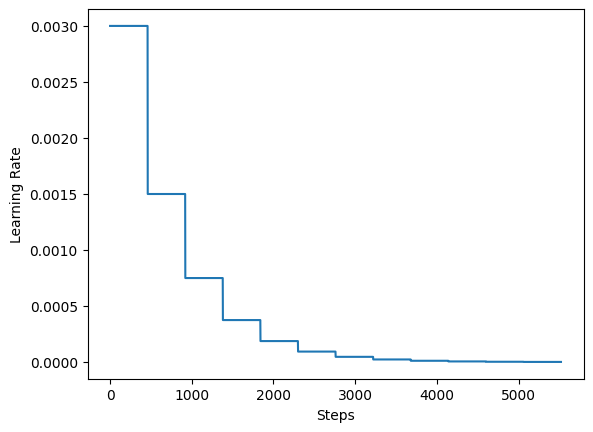

In [ ]:
steps_per_epoch = total_training_sample // batch_size
total_training_step = steps_per_epoch * epochs

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.003,
    decay_steps = steps_per_epoch * 5,
    decay_rate = 0.5,
    staircase = True)


lrs = [lr_schedule(step) for step in range(total_training_step)]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
def run_experimental(model, epochs):
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = lr_schedule),
        loss = keras.losses.CategoricalCrossentropy(),
        metrics = ["accuracy"]
    )


    checkpoint_path = "segmentation_model.weights.h5"
    checkpoint_callbacks = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor = "val_loss",
        save_best_only = True,
        save_weights_only = True)



    history = model.fit(
        train_dataset,
        validation_data = valid_dataset,
        epochs = epochs,
        callbacks = [checkpoint_callbacks])

    model.load_weights(checkpoint_path)
    return model, history

segmentation_model, history = run_experimental(segmentation_model, epochs = epochs)

Epoch 1/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 54s 336ms/step - accuracy: 0.6486 - loss: 2457.7722 - val_accuracy: 0.5391 - val_loss: 670.7332
Epoch 2/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 241ms/step - accuracy: 0.7199 - loss: 193.4981 - val_accuracy: 0.6808 - val_loss: 156.7805
Epoch 3/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 238ms/step - accuracy: 0.7440 - loss: 153.9704 - val_accuracy: 0.6773 - val_loss: 140.7835
Epoch 4/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 238ms/step - accuracy: 0.7506 - loss: 143.6136 - val_accuracy: 0.6628 - val_loss: 136.9732
Epoch 5/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.7613 - loss: 138.6807 - val_accuracy: 0.6742 - val_loss: 136.6059
Epoch 6/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.7729 - loss: 136.9916 - val_accuracy: 0.6515 - val_loss: 135.6500
Epoch 7/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.7767 - loss: 135.9279 - val_accuracy: 0.7459 - val_loss: 134.8151
Epoch 8/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.7

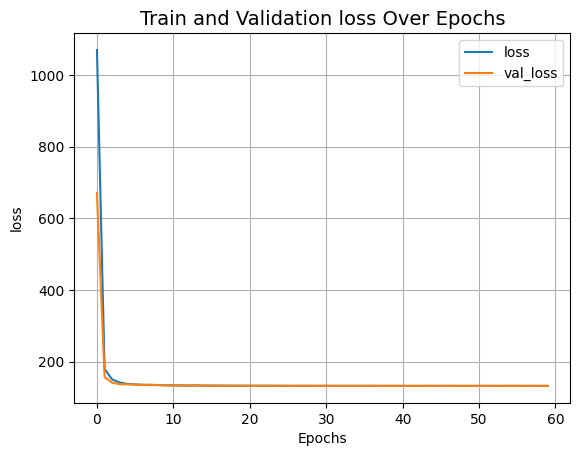

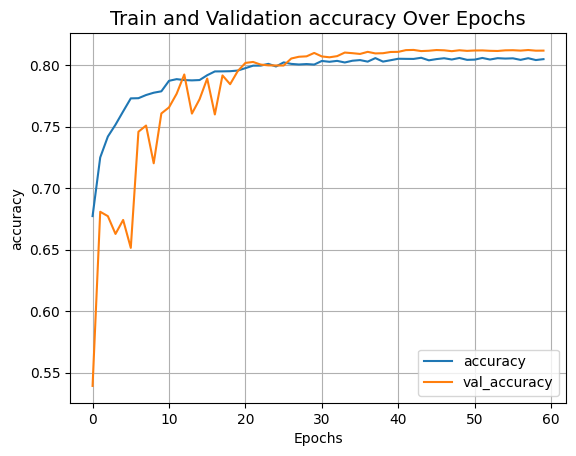

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Validation prediction shape: (32, 1024, 5)
Index selected: 24


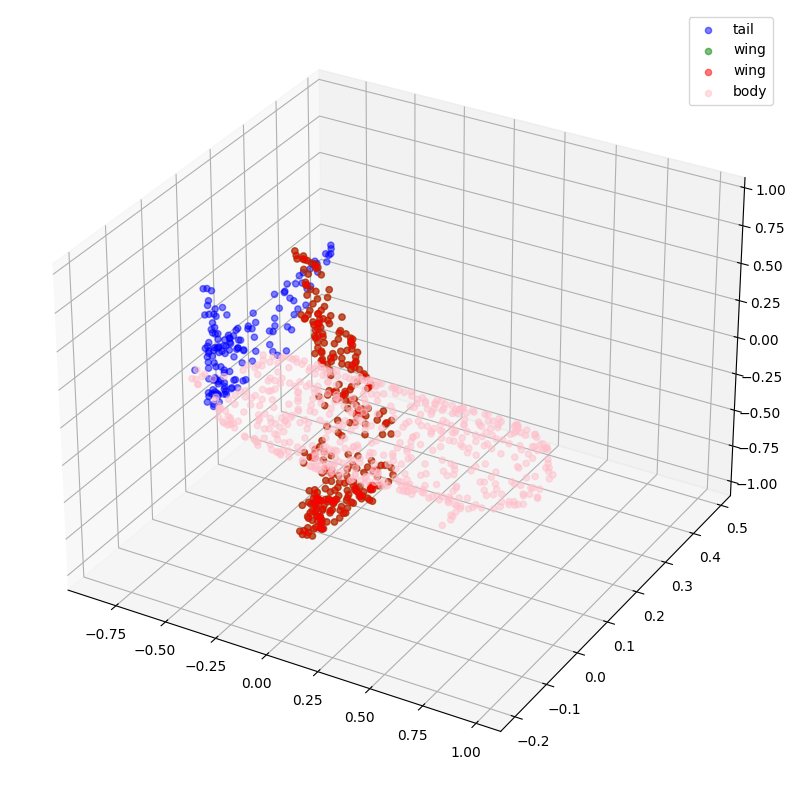

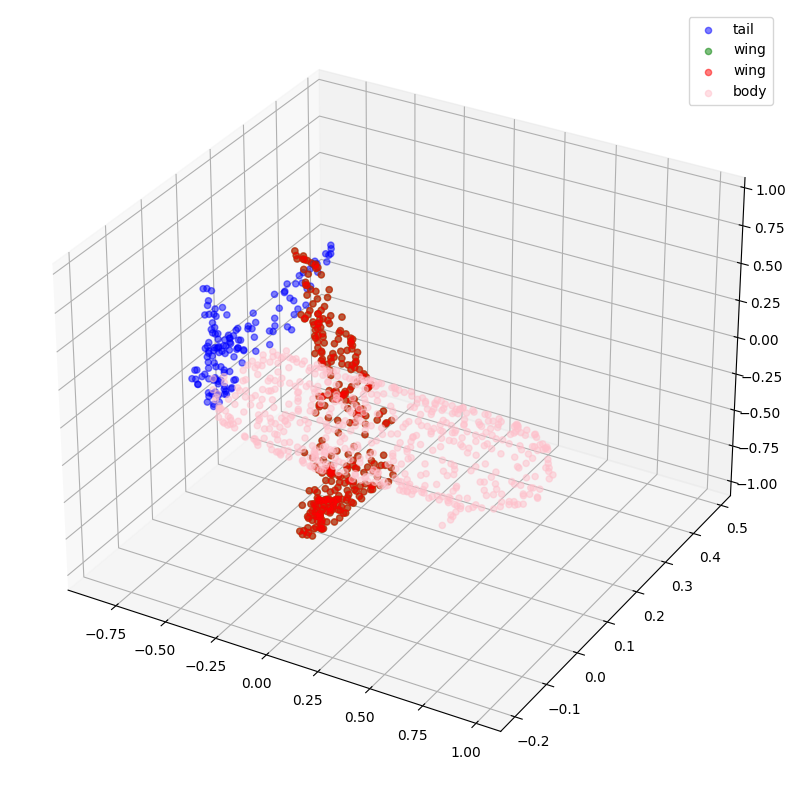

In [ ]:
validation_batch = next(iter(valid_dataset))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")


def visualize_single_point_cloud(point_clouds, label_clouds, idx):
    label_map = labels + ["none"]
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualize_data(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx)

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], val_predictions, idx)